In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('C:/Users/pz/Desktop/mss.csv')
df = pd.DataFrame(data)

In [3]:
X = df.drop(['target'], axis=1)
y = df['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,                                                     
                                                    random_state=42, stratify=df['target'])

In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [6]:
# XGBoost模型参数
params_xgb = {
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务    
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合    
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息    
    'seed': 42,                       # 随机种子，用于重现模型的结果    
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心    
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力    
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力    
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}

In [7]:
# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)

In [8]:
# 定义参数网格，用于网格搜索
param_grid = {    
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量    
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度    
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}

In [9]:
# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(    
    estimator=model_xgb,    
    param_grid=param_grid,    
    scoring='neg_log_loss',  # 评价指标为负对数损失    
    cv=5,                    # 5折交叉验证    
    n_jobs=-1,               # 并行计算    
    verbose=1                # 输出详细进度信息
)

In [10]:
# 训练模型
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constra...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=127, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=-1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_log_loss', verbose=1)

In [11]:
# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Log Loss score:  0.265660327312478


In [12]:
# 使用最优参数训练模型
best_model = grid_search.best_estimator_

In [13]:
from sklearn.metrics import classification_report
# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75        29
           1       0.93      0.92      0.93       101

    accuracy                           0.88       130
   macro avg       0.83      0.84      0.84       130
weighted avg       0.89      0.88      0.89       130



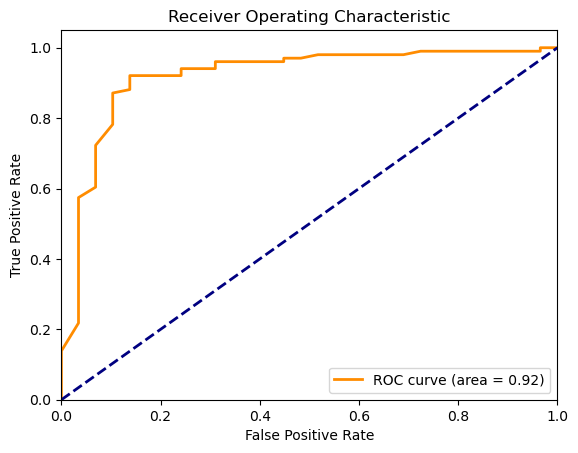

In [14]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [16]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
# Load the model
model = joblib.load('XGBoost.pkl')
# Define feature options
N_options = {    
    0: 'No lymph node metastases (0)',    
    1: 'Lymph node metastases (1)'
}
MS_options = {    
    0: 'Low group (0)',    
    1: 'High group (1)'
}
T_options = {    
    1: 'T1 (1)',    
    2: 'T2 (2)',    
    3: 'T3 (3)',
    4: 'T4 (4)'
}
# Define feature names
feature_names = [    
    "MS", "size", "T", "N"
]
# Streamlit user interface
st.title("Heart Disease Predictor")
# age: numerical input
#TMRL = st.number_input("Age:", min_value=-70, max_value=3, value=1)
size = st.number_input("Tumor size:", min_value=0.1, max_value=10, value=1)
#distance = st.number_input("Distance:", min_value=0.1, max_value=16, value=1)
# sex: categorical selection
cN = st.selectbox("cN (0=No lymph node metastases, 1=Lymph node metastases):", options=[0, 1], format_func=lambda x: 'No lymph node metastases (0)' if x == 0 else 'Lymph node metastases (1)')
# cp: categorical selection
#cp = st.selectbox("Chest pain type:", options=list(cp_options.keys()), format_func=lambda x: cp_options[x])
# trestbps: numerical input
#trestbps = st.number_input("Resting blood pressure (trestbps):", min_value=50, max_value=200, value=120)
# chol: numerical input
#chol = st.number_input("Serum cholesterol in mg/dl (chol):", min_value=100, max_value=600, value=200)
# fbs: categorical selection
MS = st.selectbox("MS (0=Low group, 1=High group):", options=[0, 1], format_func=lambda x: 'False (0)' if x == 0 else 'True (1)')
# restecg: categorical selection
#restecg = st.selectbox("Resting electrocardiographic results:", options=list(restecg_options.keys()), format_func=lambda x: restecg_options[x])
# thalach: numerical input
#thalach = st.number_input("Maximum heart rate achieved (thalach):", min_value=50, max_value=250, value=150)
# exang: categorical selection
#exang = st.selectbox("Exercise induced angina (exang):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')
# oldpeak: numerical input
#oldpeak = st.number_input("ST depression induced by exercise relative to rest (oldpeak):", min_value=0.0, max_value=10.0, value=1.0)
# slope: categorical selection
#slope = st.selectbox("Slope of the peak exercise ST segment (slope):", options=list(slope_options.keys()), format_func=lambda x: slope_options[x])
# ca: numerical input
#ca = st.number_input("Number of major vessels colored by fluoroscopy (ca):", min_value=0, max_value=4, value=0)
# thal: categorical selection
T = st.selectbox("T (T):", options=list(thal_options.keys()), format_func=lambda x: thal_options[x])
# Process inputs and make predictions
feature_values = [TMRL, size, distance, cN]
features = np.array([feature_values])
if st.button("Predict"):    
    # Predict class and probabilities    
    predicted_class = model.predict(features)[0]    
    predicted_proba = model.predict_proba(features)[0]
    # Display prediction results    
    st.write(f"**Predicted Class:** {predicted_class}")    
    st.write(f"**Prediction Probabilities:** {predicted_proba}")
    # Generate advice based on prediction results    
    probability = predicted_proba[predicted_class] * 100
    if predicted_class == 1:        
        advice = (            
            #f"According to our model, you have a high risk of heart disease. "            
            f"The model predicts that your probability of having pCR is {probability:.1f}%. "            
       # "While this is just an estimate, it suggests that you may be at significant risk. "            
        #"I recommend that you consult a cardiologist as soon as possible for further evaluation and "            
        #"to ensure you receive an accurate diagnosis and necessary treatment."        
        )    
    else:        
        advice = (            
            #f"According to our model, you have a low risk of heart disease. "            
            f"The model predicts that your probability of not having pCR is {probability:.1f}%. "            
        #"However, maintaining a healthy lifestyle is still very important. "            
        #"I recommend regular check-ups to monitor your heart health, "            
        #"and to seek medical advice promptly if you experience any symptoms."        
        )
    st.write(advice)
    # Calculate SHAP values and display force plot    
    explainer = shap.TreeExplainer(model)    
    shap_values = explainer.shap_values(pd.DataFrame([feature_values], columns=feature_names))
    shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame([feature_values], columns=feature_names), matplotlib=True)    
    plt.savefig("shap_force_plot.png", bbox_inches='tight', dpi=1200)
    st.image("shap_force_plot.png")

IndentationError: unexpected indent (2287309968.py, line 11)